HW2_Yizhen Xu


In [0]:
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19,ResNet50, InceptionV3

In [56]:
!unzip brain_tumor_dataset.zip  

Archive:  brain_tumor_dataset.zip
replace brain_tumor_dataset/no/1 no.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
# Extracting all filenames iteratively from brain_tumor_dataset folder
base_path = 'brain_tumor_dataset'
categories = ['yes', 'no']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

In [58]:
#load image data
from keras.preprocessing import image
from keras.preprocessing.image import load_img
import numpy as np
from PIL import Image

img = load_img('brain_tumor_dataset/yes/Y26.jpg')
# report details about the image
print(type(img))
print(img.format)
print(img.mode)
print(img.size)

<class 'PIL.JpegImagePlugin.JpegImageFile'>
JPEG
RGB
(628, 630)


In [0]:
# Import image, load to array of shape height, width, channels, then min/max transform.
from keras.preprocessing import image
import numpy as np
from PIL import Image

def load_image(img_path):
        img = Image.open(img_path).convert("RGB").resize((224,224)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-np.float32(img).min())/(np.float32(img).max()-np.float32(img).min()) # min max transformation
        img=img.reshape((224,224,3)) # Create final shape as array with correct dimensions for Keras
        return img

# read in all images from filenames

preprocessed_image_data=list(map(load_image, fnames[0]+fnames[1])) 

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data)

In [60]:
print(len(preprocessed_image_data) ) #same number of elements as filenames
print(preprocessed_image_data[0].shape ) #dimensions now 192,192,3 for all images
print(preprocessed_image_data[0].min() ) #min value of every image is zero
print(preprocessed_image_data[0].max() ) #max value of every image is one
X.shape

253
(224, 224, 3)
0.0
1.0


(253, 224, 224, 3)

In [61]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

yes=list(repeat("yes", 155))
no=list(repeat("no", 98))


#combine into single list of y labels
y_labels = yes+no

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

253


,no,yes
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
248,1,0
249,1,0
250,1,0
251,1,0


1.Visualize brain tumor images that demonstrate when images have tumors and when they do not have tumors.

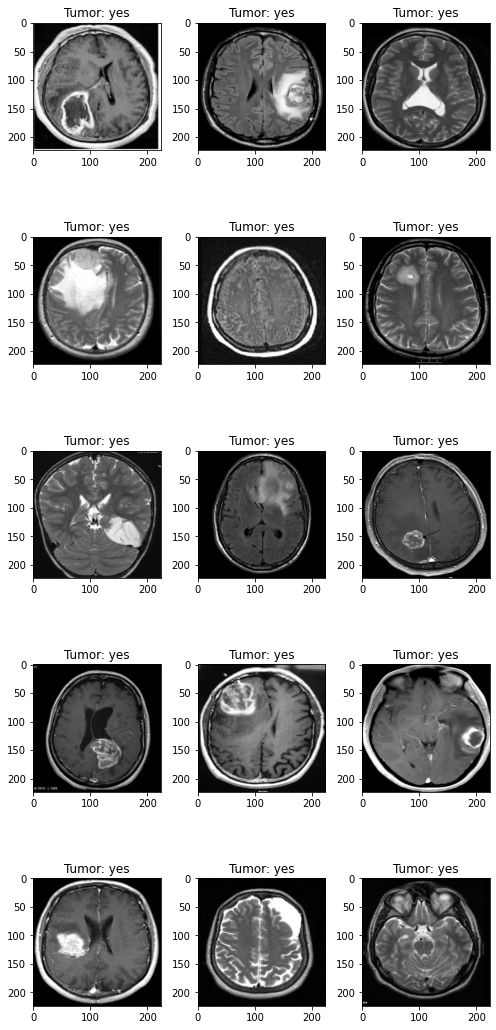

In [62]:
#when images have tumors (total:155) only demonstrate 15 of them
preprocessed_image_data_have=list(map(load_image, fnames[0])) 
X_have = np.array(preprocessed_image_data_have)

fig,ax=plt.subplots(5,3)
fig.set_size_inches(7,15)
for i in range(5):
    for j in range (3):
        l= np.random.randint(0,155) #155 is the total number of images that have tumors
        ax[i,j].imshow(X_have[l])
        ax[i,j].set_title('Tumor: yes')
        
plt.tight_layout()


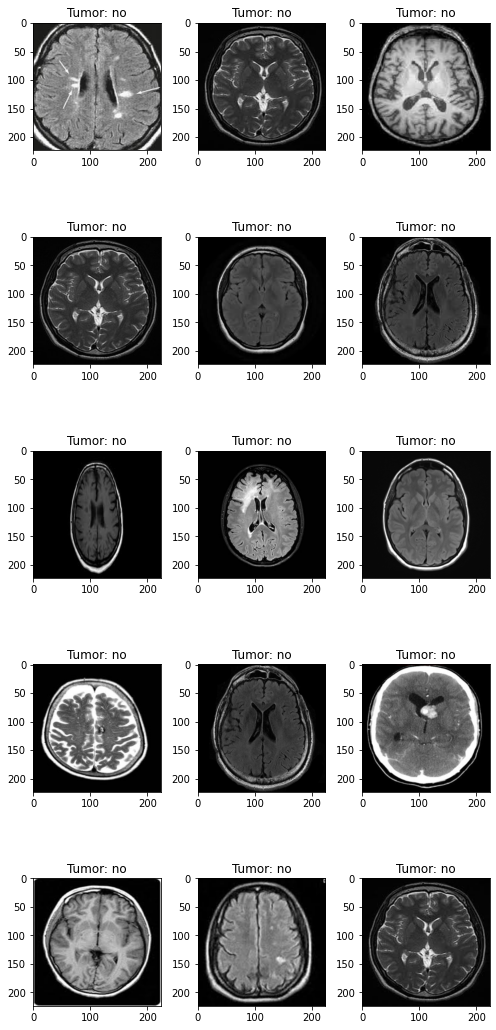

In [63]:
#when images don't have tumors (total:98) only demonstrate 15 of them
preprocessed_image_data_not_have=list(map(load_image, fnames[1])) 
X_not_have = np.array(preprocessed_image_data_not_have)

fig,ax=plt.subplots(5,3)
fig.set_size_inches(7,15)
for i in range(5):
    for j in range (3):
        l= np.random.randint(0,98) #98 is the total number of images that don't have tumors
        ax[i,j].imshow(X_not_have[l])
        ax[i,j].set_title('Tumor: no')
        
plt.tight_layout()

2.Discuss why building a predictive model using this data might be practically useful.  Who could benefit from a model like this? Explain.

Building a predictive modeling using this data is practically useful because it's beneficial for both doctors and patients themselves.
For doctors, with this model, they can improve diagnose for patients. Only using experience to assess whether a patient has a tumor with the brain CT image might be misleading due to some assessment biases. But with this model, it can improve accuracy for diagnoses and it's more scientific.
For patients themselves, they might be able to diagnose themselves. When they are in hurry and the hospital is lack of equipments and workforce to treat with them, they can upload their own brain CT image to the model and get a result. It's more convenient.

3.Run at least three prediction models to try to predict brain tumor MRI images well

In [64]:
# Train test split resized images
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=42)

y_train 

,no,yes
38,0,1
143,0,1
84,0,1
55,0,1
217,1,0
...,...,...
106,0,1
14,0,1
92,0,1
179,1,0


Model 1

In [65]:
# Model 1
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,BatchNormalization,Flatten
from tensorflow.keras.optimizers import SGD
with tf.device('/device:GPU:0'):

  model1 = tf.keras.Sequential([   
    tf.keras.layers.Conv2D(kernel_size=18, filters=32, padding='same', activation='relu', input_shape=[224, 224, 3]),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=8, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 2 categories
    tf.keras.layers.Dense(2, activation='softmax')])


  model1.compile(
    optimizer="adam", 
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model1.fit(X_train, y_train, epochs = 5, verbose=1,validation_data=(X_test,y_test)) 

Epoch 1/5
7/7 [==============================] - 43s 6s/step - loss: 0.6624 - accuracy: 0.6337 - val_loss: 0.6693 - val_accuracy: 0.5294
Epoch 2/5
7/7 [==============================] - 41s 6s/step - loss: 0.5593 - accuracy: 0.6584 - val_loss: 0.8912 - val_accuracy: 0.5686
Epoch 3/5
7/7 [==============================] - 41s 6s/step - loss: 0.5233 - accuracy: 0.7772 - val_loss: 0.6786 - val_accuracy: 0.7255
Epoch 4/5
7/7 [==============================] - 41s 6s/step - loss: 0.4837 - accuracy: 0.7871 - val_loss: 0.6448 - val_accuracy: 0.6863
Epoch 5/5
7/7 [==============================] - 41s 6s/step - loss: 0.4708 - accuracy: 0.7723 - val_loss: 0.9195 - val_accuracy: 0.6275


Model 2

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,BatchNormalization,Flatten
from tensorflow.keras.optimizers import SGD
with tf.device('/device:GPU:0'):

  model2 = tf.keras.Sequential([   
    tf.keras.layers.Conv2D(kernel_size=18, filters=32, padding='same', activation='relu', input_shape=[224, 224, 3]),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=8, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 2 categories
    tf.keras.layers.Dense(2, activation='softmax')])
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs
   
  model2.compile(
    optimizer='adam', # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model2.fit(X_train, y_train, epochs = 5, verbose=1,validation_data=(X_test,y_test),callbacks=red_lr)

Epoch 1/5
7/7 [==============================] - 41s 6s/step - loss: 0.7131 - accuracy: 0.6089 - val_loss: 0.7156 - val_accuracy: 0.5294 - lr: 0.0010
Epoch 2/5
7/7 [==============================] - 41s 6s/step - loss: 0.6281 - accuracy: 0.6386 - val_loss: 0.6748 - val_accuracy: 0.5294 - lr: 0.0010
Epoch 3/5
7/7 [==============================] - 41s 6s/step - loss: 0.5856 - accuracy: 0.6485 - val_loss: 0.7267 - val_accuracy: 0.6078 - lr: 0.0010
Epoch 4/5
7/7 [==============================] - 41s 6s/step - loss: 0.5073 - accuracy: 0.7673 - val_loss: 0.7935 - val_accuracy: 0.6863 - lr: 0.0010
Epoch 5/5
7/7 [==============================] - 41s 6s/step - loss: 0.4949 - accuracy: 0.7871 - val_loss: 0.6590 - val_accuracy: 0.6863 - lr: 0.0010


Model 3

In [0]:
# Model 3
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K


# load model new input layer shape.
IMG_SHAPE = (224, 224, 3)

# Create the base model from the pre-trained model VGG16
base_model = InceptionResNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.summary() # Notice unfrozen number of trainable parameters

219062272/219055592 [==============================] - 2s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d_12[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_____________

In [0]:
# Next step: Freeze the weights of the model so that they are not trained with you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_model.trainable = False

base_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d_12[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

In [0]:
# Add new GAP layer and output layer to frozen layers of original model with adjusted input
model3 = Sequential([
  base_model,
   GlobalAveragePooling2D(),
   Dense(2,activation="softmax")
])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 5, 5, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 3074      
Total params: 54,339,810
Trainable params: 3,074
Non-trainable params: 54,336,736
_________________________________________________________________


In [0]:
# Fit Inception model with frozen imagenet weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): 

  model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model3.fit(X_train, y_train,epochs = 5, verbose=1,validation_data=(X_test,y_test))

Epoch 1/5
7/7 [==============================] - 29s 4s/step - loss: 0.7075 - acc: 0.6188 - val_loss: 0.7185 - val_acc: 0.4902
Epoch 2/5
7/7 [==============================] - 25s 4s/step - loss: 0.4543 - acc: 0.8168 - val_loss: 0.6691 - val_acc: 0.5882
Epoch 3/5
7/7 [==============================] - 25s 4s/step - loss: 0.3723 - acc: 0.8416 - val_loss: 0.5808 - val_acc: 0.6667
Epoch 4/5
7/7 [==============================] - 25s 4s/step - loss: 0.3207 - acc: 0.8911 - val_loss: 0.5593 - val_acc: 0.7255
Epoch 5/5
7/7 [==============================] - 25s 4s/step - loss: 0.2763 - acc: 0.9010 - val_loss: 0.5598 - val_acc: 0.7255


4.Submit your best model to the leader board for the Brain Tumor Diagnostic AI Model Share competition.

The best model is model 3. Because the highest test accuracy for model 1 is 0.7059, the highest test accuracy for model 2 is 0.6863, and the highest test accuracy for model 3 is 0.7647.

In [66]:
# Load libraries for onnx model conversion (keras to onnx)
! pip3 install keras2onnx
! pip3 install onnxruntime

In [0]:
import os
os.environ['TF_KERAS'] = '1' 
import onnx

import keras2onnx

from keras2onnx import convert_keras
onx = convert_keras(model1, 'my_model.onnx')
with open("my_model.onnx", "wb") as f:
    f.write(onx.SerializeToString())

In [68]:
model1.evaluate(X_test,y_test)

2/2 [==============================] - 1s 453ms/step - loss: 0.9195 - accuracy: 0.6275


[0.9194612503051758, 0.6274510025978088]

In [105]:
# using predict_classes() for multi-class data to return predicted class index.

def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

print(predict_classes(model3.predict(X_test)))

prediction_index=predict_classes(model3.predict(X_test))

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

[0 1 1 0 1 0 0 1 1 0 0 0 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 0 1 0 1
 1 1 1 0 1 1 1 1 1 1 1 0 1 1]
['no', 'yes', 'yes', 'no', 'yes', 'no', 'no', 'yes', 'yes', 'no', 'no', 'no', 'yes', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes']


In [0]:
# Now we can extract some evaluative metrics to use for model submission

import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from math import sqrt

def model_eval_metrics(y_true, y_pred,classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata

In [107]:
# y_test is one hot encoded so we need to extract labels before runing model_eval_metrics()
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object

model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.72549,0.712097,0.749107,0.715278,0,0,0,0


In [72]:
# add metrics to submittable object
modelevalobject=model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")


modelevalobject# add metrics to submittable object


,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.72549,0.712097,0.749107,0.715278,0,0,0,0


In [79]:
#install aimodelshare library
! pip3 install https://github.com/mikedparrott/aimodelshare/blob/master/aimodelshare-0.0.5.tar.gz?raw=true

  Created wheel for aimodelshare: filename=aimodelshare-0.0.5-cp36-none-any.whl size=5305 sha256=4408ff514cb79a16a14c8d0aff1d553371a706c2324624627da9672c1ac45f22
  Stored in directory: /root/.cache/pip/wheels/ab/28/ae/b9ecb7a3a5542d3f2fed56649fdd6dec1c16f900ef70b93875
Successfully built aimodelshare
  Found existing installation: aimodelshare 0.0.3
    Uninstalling aimodelshare-0.0.3:
      Successfully uninstalled aimodelshare-0.0.3


In [0]:
# Example Model Pre-launched into Model Share Site
apiurl="https://a53yv0xqce.execute-api.us-east-1.amazonaws.com/prod/m"
username = "XU"
password = "MayDay12345"

model_filepath="my_model.onnx"   

# New! Assign model object to model argument parameter to submit model architecture to leaderboard.
model=model1

# Set aws keys for this project (these keys give you access to collaborate on a single project)

#Importing from object that stores keys so we do not print out keys for others to see.

import pickle
aws_key_password_region = pickle.load( open( "braintumor_modelsubmission_keys.pkl", "rb" ) )

aws_key=aws_key_password_region[0]
aws_password=aws_key_password_region[1]
region=aws_key_password_region[2]

In [94]:
# Submit your model using submit_model() function
# Works with models and preprocessors. 
import aimodelshare as ai

ai.submit_model(model_filepath=model_filepath, model_eval_metrics=modelevalobject,apiurl=apiurl, username=username, password=password, aws_key=aws_key,aws_password=aws_password, region=region, trainingdata="default",preprocessor_filepath="default",preprocessor="default")

TypeError: ignored

ERROR! Session/line number was not unique in database. History logging moved to new session 60


5.Import the best model from the leader board

In [0]:
# arguments required to get leaderboard below
apiurl="https://a53yv0xqce.execute-api.us-east-1.amazonaws.com/prod/m"
username = "XU"
password = "MayDay12345"

In [91]:
import aimodelshare as ai

leaderboard = ai.get_leaderboard(apiurl, username, password, aws_key, aws_password, region)

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2,username,model_version,avg_ranking_classification,avg_ranking_regression,model_config,model_optim_config,model_epochs
15,0.941176,0.940812,0.942547,0.939815,0,0,0,0,Taketo,17,1.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
14,0.901961,0.901354,0.902950,0.900463,0,0,0,0,Taketo,16,2.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",10
16,0.875000,0.868718,0.868718,0.868718,0,0,0,0,3scman,18,3.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.01, 'decay...",25
21,0.862745,0.862745,0.865741,0.865741,0,0,0,0,dhoward97,24,4.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 1.5625e-05, ...",25
23,0.862745,0.862534,0.862308,0.863426,0,0,0,0,seanmcalevey,26,5.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'SGD', 'learning_rate': 0.001, 'decay...",50
17,0.823529,0.813187,0.875000,0.812500,0,0,0,0,AlisaAi,19,5.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",25
20,0.843137,0.841615,0.845611,0.840278,0,0,0,0,seanmcalevey,23,6.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'SGD', 'learning_rate': 0.001, 'decay...",25
13,0.803922,0.802019,0.805643,0.800926,0,0,0,0,Taketo,15,8.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
12,0.784314,0.778873,0.796053,0.777778,0,0,0,0,SUN-Wenjun,14,9.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'SGD', 'learning_rate': 0.001, 'decay...",20
3,0.784314,0.775690,0.808824,0.775463,0,0,0,0,username1,5,9.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5


5.1 Import the model's config and it's optimization config

In [92]:
#5.1 Import the model's config and it's optimization config
model_config= leaderboard.loc[0,'model_config'] 
model_optim_config= leaderboard.loc[0,'model_optim_config']

print(model_config)
print(model_optim_config)

backend: tensorflow
class_name: Sequential
config:
  layers:
  - class_name: Dense
    config:
      activation: relu
      activity_regularizer: null
      batch_input_shape: !!python/tuple [null, 224, 224, 3]
      bias_constraint: null
      bias_initializer:
        class_name: Zeros
        config: {dtype: float32}
      bias_regularizer: null
      dtype: float32
      kernel_constraint: null
      kernel_initializer:
        class_name: GlorotUniform
        config: {dtype: float32, seed: null}
      kernel_regularizer: null
      name: dense
      trainable: true
      units: 64
      use_bias: true
  - class_name: Dense
    config:
      activation: relu
      activity_regularizer: null
      bias_constraint: null
      bias_initializer:
        class_name: Zeros
        config: {dtype: float32}
      bias_regularizer: null
      dtype: float32
      kernel_constraint: null
      kernel_initializer:
        class_name: GlorotUniform
        config: {dtype: float32, seed: null}

5.2 Visualize the model's structure

In [93]:
#5.2 Visualize the model's structure
from tensorflow.keras.models import model_from_yaml
model = model_from_yaml(model_config)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 224, 224, 64)      256       
_________________________________________________________________
dense_1 (Dense)              (None, 224, 224, 64)      4160      
_________________________________________________________________
dense_2 (Dense)              (None, 224, 224, 64)      4160      
_________________________________________________________________
flatten (Flatten)            (None, 3211264)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 6422530   
Total params: 6,431,106
Trainable params: 6,431,106
Non-trainable params: 0
_________________________________________________________________


5.3 Explain how the model's structure is different from your best model.

First, I use convolutional layers Conv2d and max_pooling method while the the best model didn't. Second, I use 1 hidden layers while the best model use 3 hidden layers. Third, I have 54339810 trainable parameters while the best model has 6431106 ones.

In [108]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 5, 5, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 3074      
Total params: 54,339,810
Trainable params: 3,074
Non-trainable params: 54,336,736
_________________________________________________________________


5.4 Explain how the model's optimization approach is different from your best model

This best model uses CNN while I use transfering model.

6.Fit the best model from the leader board to training data and evaluate it on test data to complete your report.

In [96]:
# Fitting the model to the Training set
model.compile(optimizer="adam", loss= 'categorical_crossentropy',metrics=['accuracy'])

model.fit(X_train, y_train, epochs = 5, verbose=1,validation_data=(X_test,y_test)) 

Epoch 1/5
7/7 [==============================] - 10s 1s/step - loss: 2.3256 - accuracy: 0.7129 - val_loss: 3.4019 - val_accuracy: 0.6275
Epoch 2/5
7/7 [==============================] - 10s 1s/step - loss: 1.5045 - accuracy: 0.7327 - val_loss: 1.9260 - val_accuracy: 0.6667
Epoch 3/5
7/7 [==============================] - 10s 1s/step - loss: 0.4880 - accuracy: 0.7673 - val_loss: 1.1848 - val_accuracy: 0.7255
Epoch 4/5
7/7 [==============================] - 10s 1s/step - loss: 0.2862 - accuracy: 0.8960 - val_loss: 1.0917 - val_accuracy: 0.7255
Epoch 5/5
7/7 [==============================] - 10s 1s/step - loss: 0.2281 - accuracy: 0.9257 - val_loss: 1.5193 - val_accuracy: 0.6863


In [99]:
# using predict_classes() for multi-class data to return predicted class index.

def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

print(predict_classes(model.predict(X_test)))

prediction_index=predict_classes(model.predict(X_test))

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

[1 1 1 0 0 1 0 0 1 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1
 0 1 1 0 1 1 1 1 1 0 1 0 0 0]
['yes', 'yes', 'yes', 'no', 'no', 'yes', 'no', 'no', 'yes', 'yes', 'no', 'no', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'no', 'no', 'no']


In [0]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from math import sqrt

def model_eval_metrics(y_true, y_pred,classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata

In [101]:
# y_test is one hot encoded so we need to extract labels before runing model_eval_metrics()
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object

model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.686275,0.670968,0.703571,0.675926,0,0,0,0
